

<h1 style='background-color:Green; font-family:newtimeroman; font-size:180%; text-align:center; border-radius: 15px 50px;' > Chest Cancer Classification - VVG16 </h1>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install -U scikit-image

In [152]:
! pip install -q kaggle

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam

from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

# from typeguard import typechecked
from typing import Optional

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [153]:
train = "/content/train"
valid = "/content/validation"

In [154]:
def plot_imgs(item_dir, num_imgs=4):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs+1]

    plt.figure(figsize=(16, 16))
    for idx, img_path in enumerate(item_files):
        plt.subplot(1, 5,idx+1)

        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')

    plt.tight_layout()

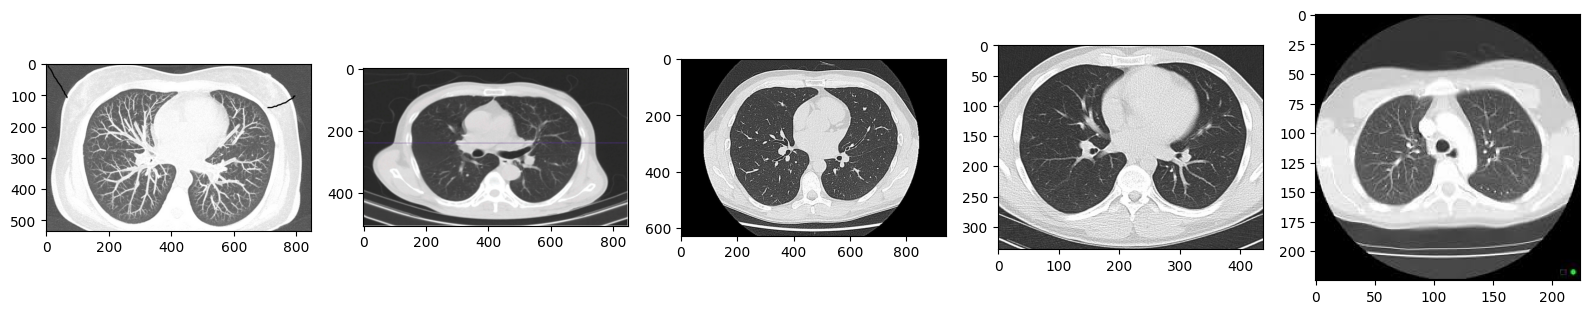

In [155]:
plot_imgs(os.path.join(train, 'Normal'))

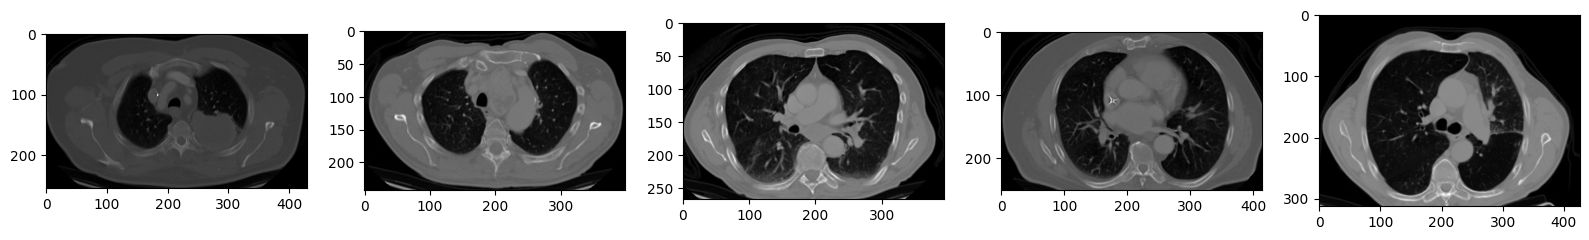

In [157]:
plot_imgs(os.path.join(train, 'large_cell'))

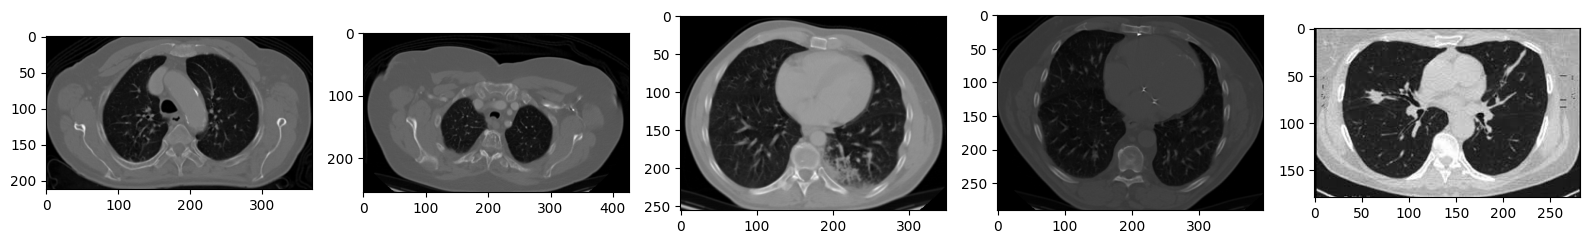

In [158]:
plot_imgs(os.path.join(train, 'Squamous'))

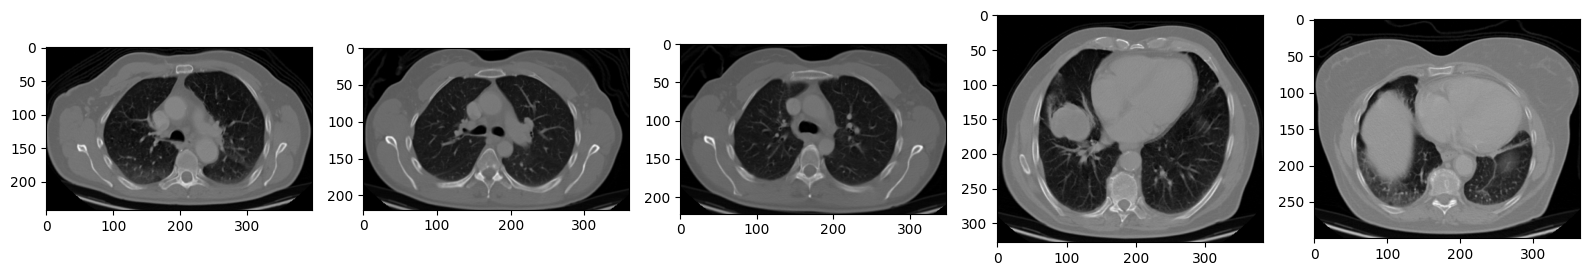

In [159]:
plot_imgs(os.path.join(train, 'Adenocarcinoma'))

In [131]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        # rotation_range=5,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
                                )

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [132]:
rm -rf `find -type d -name .ipynb_checkpoints`


In [133]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

Found 613 images belonging to 4 classes.


In [134]:
valid_dataset = test_datagen.flow_from_directory(directory = '/content/validation',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 16)

Found 72 images belonging to 4 classes.


In [137]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

94765736/94765736 [==============================] - 0s 0us/step


In [139]:
# Freezing Layers
for layer in base_model.layers[:-8]:
    layer.trainable=False

In [140]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(base_model)
#First Layer
# model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128,128,3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))

# #Second Layer
# model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))

# #Third Layer
# model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout(0.4))

# #Fourth Layer
# model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout(0.2))

# #Flattening the layers
# model.add(Flatten())

# #Adding the dense layer
# model.add(Dense(256, activation = 'relu'))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dense(4, activation = 'softmax'))

# model.summary()

In [141]:
# Building Model

model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [142]:
# Model Summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_22 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 flatten_10 (Flatten)        (None, 100352)            0         
                                                                 
 batch_normalization_8 (Bat  (None, 100352)            401408    
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 32)                3211296   
                                                                 
 batch_normalization_9 (Bat  (None, 32)                128       
 chNormalization)                                    

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [144]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [145]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [146]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.1, min_lr = 1e-7)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=3)

In [147]:
train_dataset.class_indices

{'Adenocarcinoma': 0, 'Normal': 1, 'Squamous': 2, 'large_cell': 3}

In [148]:
valid_dataset.class_indices

{'Adenocarcinoma': 0, 'Normal': 1, 'Squamous': 2, 'large_cell': 3}

In [150]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=METRICS)

In [151]:
%time
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 20,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 1.3862 - accuracy: 0.7720 - precision: 0.6646 - recall: 0.1778 - auc: 0.6143 - f1_score: 0.2853

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 23s 1s/step - loss: 1.3862 - accuracy: 0.7720 - precision: 0.6646 - recall: 0.1778 - auc: 0.6143 - f1_score: 0.2853 - val_loss: 83.7153 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1875 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.2269 - accuracy: 0.7883 - precision: 0.8264 - recall: 0.1941 - auc: 0.6785 - f1_score: 0.3122 - val_loss: 131.8652 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1875 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.2119 - accuracy: 0.7851 - precision: 0.8028 - recall: 0.1860 - auc: 0.7203 - f1_score: 0.3062 - val_loss: 127.4031 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.2125 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 1.1732 - ac

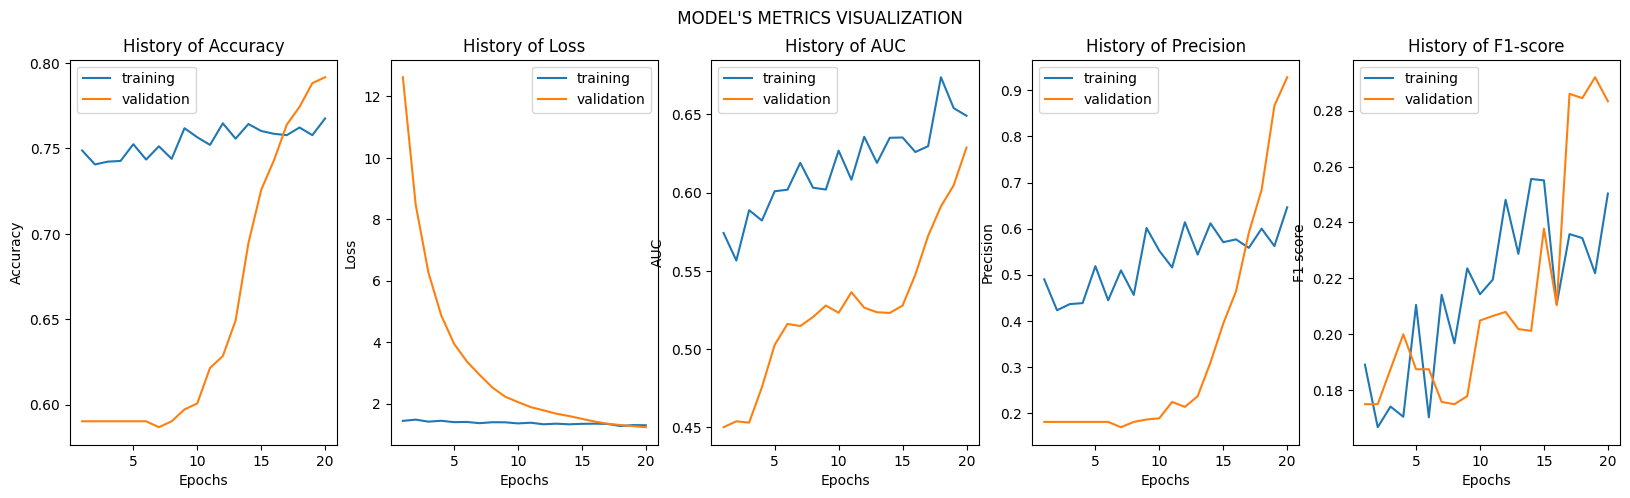

In [136]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )